In [1]:
%reload_ext autoreload
%autoreload 2

import SimpleITK as sitk
import numpy as np

import matplotlib.pyplot as plt
import subtle.utils.io as suio
from subtle.subtle_preprocess import register_im, dcm_to_sitk
from subtle.utils.experiment import get_experiment_data
from scipy.ndimage import affine_transform
import nibabel as nib
from glob import glob
from tqdm import tqdm_notebook as tqdm

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

def preprocess_vol(vol):
    vol = vol / vol.mean()
    vol = np.interp(vol, (vol.min(), vol.max()), (0, 1))
    return vol

def get_sitk_affn_mat(reg_params):
    tr_params = np.array(reg_params[0]['TransformParameters']).astype(np.float32)
    tr_params = np.array(np.array_split(tr_params, 4)).T
    tr_4x4 = np.append(tr_params, [[0, 0, 0, 1]], axis=0)
    tr_4x4_inv = np.linalg.inv(tr_4x4)
    return tr_4x4_inv[:-1]

def preprocess_img(img_vol, pad=False):
    img_vol = np.rot90(img_vol.transpose(2, 0, 1), axes=(1, 2), k=3)
    img_vol = img_vol / img_vol.mean()
    img_vol = np.interp(img_vol, (img_vol.min(), img_vol.max()), (0, 1))
    img_vol = img_vol[13:-14]
    if pad:
        img_vol = np.pad(img_vol, pad_width=[(0, 0), (8, 8), (8, 8)], mode='constant', constant_values=0)
    return img_vol

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


<Figure size 432x288 with 0 Axes>

In [3]:
cases = get_experiment_data('stanford_sri', 
                            dirpath_exp='/home/srivathsa/projects/SubtleGad/train/configs/experiments/',
                            dataset='all',
                            fname='data_vmorph'
                           )

src_path = '/home/srivathsa/projects/studies/gad/stanford/data'
dest_path = '/home/srivathsa/projects/studies/gad/stanford/preprocess/aff_params'

for cnum in tqdm(cases, total=len(cases)):
    fpath_pre, fpath_low, _ = suio.get_dicom_dirs('{}/{}'.format(src_path, cnum))

    vol1, _ = suio.dicom_files(fpath_pre)
    vol1 = preprocess_vol(vol1)

    vol2, _ = suio.dicom_files(fpath_low)
    vol2 = preprocess_vol(vol2)
    
    ref_zero = dcm_to_sitk(fpath_pre)
    ref_low = dcm_to_sitk(fpath_low)

    pmap = sitk.GetDefaultParameterMap('affine')
    vol2_reg, reg_params = register_im(vol1, vol2, param_map=pmap, verbose=0, 
                           ref_fixed=ref_zero, ref_moving=ref_low)
    
    aff_mtx = get_sitk_affn_mat(reg_params)
#     np.save('{}/{}.npy'.format(dest_path, cnum), aff_mtx)
    break

/home/srivathsa/miniconda3/envs/voxelmorph/lib/python3.7/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


  0%|          | 0/441 [00:00<?, ?it/s]

image registration
registration done, 18.3 s


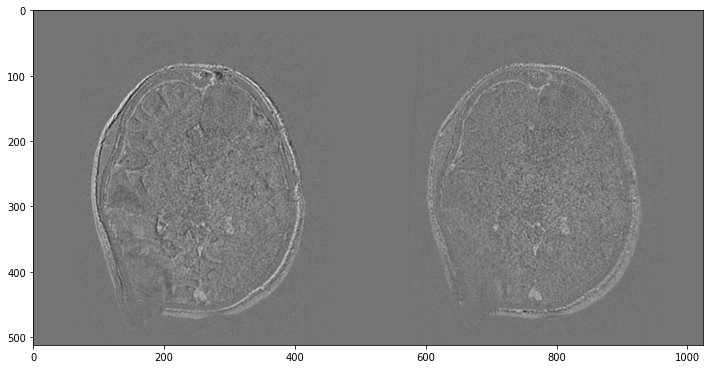

In [4]:
ref_zero = dcm_to_sitk(fpath_pre)
ref_low = dcm_to_sitk(fpath_low)

pmap = sitk.GetDefaultParameterMap('affine')
vol2_reg, reg_params = register_im(vol1, vol2, param_map=pmap, verbose=1, 
                       ref_fixed=ref_zero, ref_moving=ref_low)

plt.imshow(np.hstack([vol2[180] - vol1[180], vol2_reg[180] - vol1[180]]))

In [18]:
aff_mtx = get_sitk_affn_mat(reg_params)
bvol1 = nib.load('/home/srivathsa/projects/brats_2021/data/val/BraTS2021_00035/BraTS2021_00035_t1.nii.gz').get_fdata()
bvol1 = preprocess_img(bvol1, pad=True)

bvol2 = nib.load(
    '/home/srivathsa/projects/brats_2021/data/val/BraTS2021_00035/BraTS2021_00035_t1ce.nii.gz'
).get_fdata()
bvol2 = preprocess_img(bvol2, pad=True)

bvol2_tfm = affine_transform(bvol2, aff_mtx)

In [12]:
aff_mtx

array([[ 0.99968488,  0.00142475,  0.0049612 ,  0.28487287],
       [-0.00198392,  0.99989446, -0.00480875,  0.0173794 ],
       [-0.00450519,  0.00472979,  0.99980497, -0.03075868]])

In [15]:
aff_mtx + np.random.normal(loc=0, scale=1e-4, size=(3, 4))

array([[ 0.99997366,  0.00131168,  0.0050358 ,  0.28507286],
       [-0.00231077,  0.99979025, -0.0047816 ,  0.01737972],
       [-0.00445587,  0.00469736,  0.99975964, -0.03079743]])

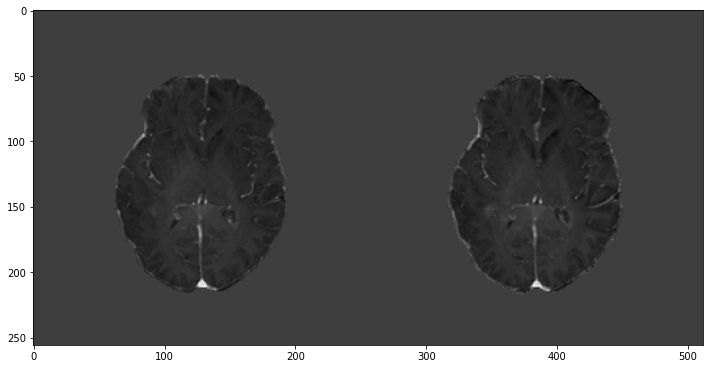

In [19]:
diff1 = bvol2 - bvol1
diff2 = bvol2_tfm - bvol1
plt.imshow(np.hstack([diff1[64], diff2[64]]))

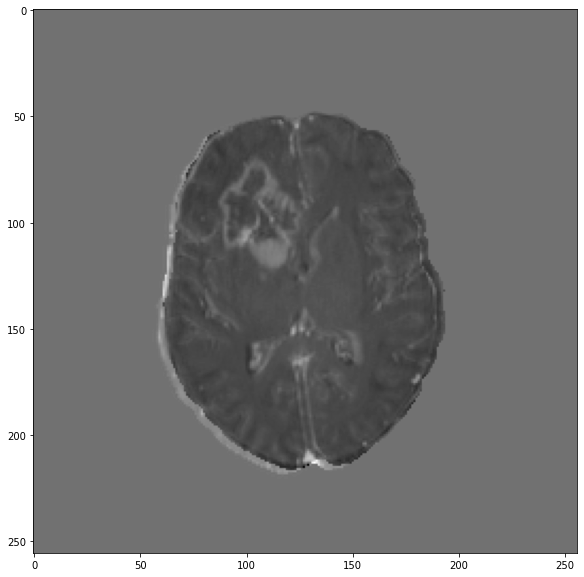

In [22]:
t1, t1ce = np.load('/home/srivathsa/projects/studies/gad/vmorph/data/brats_real/train/BraTS2021_00000.npz')['data']

plt.imshow(np.hstack([t1ce[64] - t1[64]]))